<a href="https://colab.research.google.com/github/prstevens910/exploreAppleHealthDat_Sp25/blob/main/HealthDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview

The goal of this project is to use health data (downloaded from my iPhone's Health app) to make some observations about the way my activity and biometrics vary over time - rhythms for weekdays versus weekends, winter versus summer, etc.


## Data loading

The app initially exported data as an .xml file with a lot of metadata and empty lines - I cleaned this up a bit in R before loading it here, making it a .csv format, but we'll still have some pre-processing to do.


In [ ]:
import pandas as pd

df = pd.read_csv('cleaned_health_dat.csv')
display(df.head())

,recordType,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value
0,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 16:16:55 -0600,2018-05-17 15:34:08 -0600,2018-05-17 15:43:56 -0600,10.0
1,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 16:16:55 -0600,2018-05-17 15:47:44 -0600,2018-05-17 15:56:51 -0600,98.0
2,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:19:03 -0600,2018-05-17 16:29:01 -0600,242.0
3,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:29:01 -0600,2018-05-17 16:39:01 -0600,524.0
4,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:39:01 -0600,2018-05-17 16:41:42 -0600,65.0


## Data exploration & pre-processing
Explore the loaded dataset to understand its structure, identify relevant columns, check for missing values or inconsistencies, and identify if any variables need to be reformatted or mutated to get useful information.


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\n** Missing Values: **\n", missing_values)

# Inspect data types
print("\n** Data Types: **")
print(df.dtypes)


** Missing Values: **
 recordType       0
sourceName       0
sourceVersion    0
unit             0
creationDate     0
startDate        0
endDate          0
value            0
dtype: int64

** Data Types: **
recordType        object
sourceName        object
sourceVersion     object
unit              object
creationDate      object
startDate         object
endDate           object
value            float64
dtype: object


No missing data for any of the variables, which makes things easier. <br> One thing that immediately stands out to me is that the date variables (`creationDate`, `startDate`, `endDate`) are not recognized as dates. Let's fix that first - what date format are these variables using?

In [ ]:
print("\nUnique values in 'startDate' (first 5):\n", df['startDate'].unique()[:5])
print("\nFor 'endDate':\n", df['endDate'].unique()[:5])
print("\nFor 'creationDate':\n", df['creationDate'].unique()[:5])


Unique values in 'startDate' (first 5):
 ['2018-05-17 15:34:08 -0600' '2018-05-17 15:47:44 -0600'
 '2018-05-17 16:19:03 -0600' '2018-05-17 16:29:01 -0600'
 '2018-05-17 16:39:01 -0600']

For 'endDate':
 ['2018-05-17 15:43:56 -0600' '2018-05-17 15:56:51 -0600'
 '2018-05-17 16:29:01 -0600' '2018-05-17 16:39:01 -0600'
 '2018-05-17 16:41:42 -0600']

For 'creationDate':
 ['2018-05-17 16:16:55 -0600' '2018-05-17 17:10:51 -0600'
 '2018-05-17 18:17:11 -0600' '2018-05-17 19:14:17 -0600'
 '2018-05-17 20:12:46 -0600']


These time stamps are structured as date - time - UTC offset, or in the language of Pandas, `'%Y-%m-%d %H:%M:%S %z'`, so let's format them that way for easier processing later.

In [ ]:

try:
  df['startDate'] = pd.to_datetime(df['startDate'], format='%Y-%m-%d %H:%M:%S %z')
  df['endDate'] = pd.to_datetime(df['endDate'], format='%Y-%m-%d %H:%M:%S %z')
  df['creationDate'] = pd.to_datetime(df['creationDate'], format='%Y-%m-%d %H:%M:%S %z')
except:
  'Failed to convert one of dates to provided format'

# check that all "Year" values from these dates are reasonable, given that data is all from 2018 to 2025
print("\nUnique years from 'startDate':\n", df['startDate'].dt.year.unique())
print("\nFrom 'endDate':\n", df['endDate'].dt.year.unique())
print("\nFrom 'creationDate':\n", df['creationDate'].dt.year.unique())




Unique years from 'startDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]

From 'endDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]

From 'creationDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]


It looks like all the date variables have been properly formatted. Next, let's look closer at what kinds of information `recordType`,`sourceName`, `sourceVersion`, and `unit` contain.

In [ ]:
print("\nUnique values in 'recordType':\n", df['recordType'].unique())
print("\nUnique values in 'sourceName':\n", df['sourceName'].unique())
print("\nUnique values in 'sourceVersion':\n", df['sourceVersion'].unique())
print("\nUnique values in 'unit':\n", df['unit'].unique())


Unique values in 'recordType':
 ['StepCount' 'DistanceWalkingRunning' 'BasalEnergyBurned'
 'ActiveEnergyBurned' 'FlightsClimbed' 'HeadphoneAudioExposure'
 'WalkingDoubleSupportPercentage' 'WalkingSpeed' 'WalkingStepLength'
 'WalkingAsymmetryPercentage' 'AppleWalkingSteadiness']

Unique values in 'sourceName':
 ['iPhone (73)']

Unique values in 'sourceVersion':
 ['11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3, creation date:2018-05-17 21:40:10 +0000&gt;'
 '11.3 device=&lt;&lt;HKDevice: 0x461c34780&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3, creation date:2018-05-17 21:40:10 +0000&gt;'
 '11.3.1 device=&lt;&lt;HKDevice: 0x461c36e40&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3.1, creation date:2018-05-24 05:02:16 +0000&gt;'
 ...
 '2956.0.7 device=&lt;&lt;HKDevice: 0x4617a2850&gt;, name:iPhone, manufacturer:Apple Inc., mode

The unique values for `recordType` and `unit` are reasonably self-explanatory (providing the metric for that row as well as the units in which it's measured), and `sourceName` is always the same. <br><br>
`sourceVersion`, on the other hand, appears to contain a variety of types of information that might be worth breaking out. For example, it might be interesting to investigate how new hardware (i.e., when I upgraded from iPhone 10 to iPhone 13) might impact precision or biases of these metrics. We can create new variables by splitting the `sourceVersion` string on ", ":

In [ ]:
import numpy as np
df['rowInd'] = np.arange(df.shape[0]) # add row index for main data frame, for data re-merging later.

df2 = pd.DataFrame(df[['rowInd','sourceVersion']].copy())

# split up strings and assign to new variables
df2['text_split'] = df2['sourceVersion'].str.split(', ',n=-1)
df2 = df2.explode('text_split')
df2[['var','val']] = df2['text_split'].str.split(':',n=1,expand=True)

# filter out the source version preamble and creation date, don't care about those
df2 = df2.loc[df2['var'].isin(['name', 'manufacturer', 'model', 'hardware', 'software'])]# NOTE: svName is where headphone types can be distinguished.

# pivot so 'var' values become columns, rename columns
pivoted_df = df2.pivot(index='rowInd', columns='var', values='val')
pivoted_df = pivoted_df.rename(columns={'name': 'svName','hardware': 'svHardware','software': 'svSoftware','manufacturer': 'svManufacturer','model': 'svModel'})

# # Merge pivoted data back to the original DataFrame
df_sp = pd.merge(df, pivoted_df, left_index=True, right_on='rowInd', how='left')
df_sp = df_sp.drop(columns = ['rowInd','sourceVersion'])

# Display the updated DataFrame
display(df_sp.head())

,recordType,sourceName,unit,creationDate,startDate,endDate,value,svHardware,svManufacturer,svModel,svName,svSoftware
rowInd,,,,,,,,,,,,
0,StepCount,iPhone (73),count,2018-05-17 16:16:55-06:00,2018-05-17 15:34:08-06:00,2018-05-17 15:43:56-06:00,10.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
1,StepCount,iPhone (73),count,2018-05-17 16:16:55-06:00,2018-05-17 15:47:44-06:00,2018-05-17 15:56:51-06:00,98.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
2,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:19:03-06:00,2018-05-17 16:29:01-06:00,242.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
3,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:29:01-06:00,2018-05-17 16:39:01-06:00,524.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
4,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:39:01-06:00,2018-05-17 16:41:42-06:00,65.0,"iPhone10,4",Apple,iPhone,iPhone,11.3


Now that we've successfully split up the `sourceVersion` values into several more informative variables, let's take a look at how `value` varies across the different values of `recordType`.

First, notice how in the data frame above there are step count records on May 17th, 2018 for 3:34 to 3:43 pm, 3:47 to 3:56 pm, etc. Let's see if the duration is consistent across these records (making them comparable).

In [ ]:
df_sp['recordDur'] = df_sp['endDate'] - df_sp['startDate'] # Calculate difference between start and end of record
print('Mean duration:')
print(str(round(df_sp['recordDur'].dt.total_seconds().mean(),2))+' seconds')
print('\nStandard deviation of durations:')
print(str(round(df_sp['recordDur'].dt.total_seconds().std(),2))+' seconds')


Mean duration:
747.57 seconds

Standard deviation of durations:
14275.93 seconds


 Unfortunately, record durations appear to vary quite a bit (standard deviation of 14,000 seconds, or around 4 hours). It will be more informative for our purposes to look at sums for these values across the whole day, so that different examples within the same record type are comparable.

In [ ]:
unique_creationDate = np.unique(df_sp['creationDate'].dt.date)
unique_recTypes = np.unique(df_sp['recordType'])
sums = df_sp.groupby([df_sp['creationDate'].dt.date, 'recordType'])['value'].sum().reset_index() # take sum for each JustDate, recordType combination, turn back into data frame.

print(sums)

      creationDate                      recordType        value
0       2018-05-17          DistanceWalkingRunning     1.566136
1       2018-05-17                       StepCount  3519.000000
2       2018-05-18          DistanceWalkingRunning     0.558532
3       2018-05-18                  FlightsClimbed     1.000000
4       2018-05-18                       StepCount  1304.000000
...            ...                             ...          ...
16021   2025-05-02                       StepCount   270.000000
16022   2025-05-02      WalkingAsymmetryPercentage     0.000000
16023   2025-05-02  WalkingDoubleSupportPercentage     0.534000
16024   2025-05-02                    WalkingSpeed     6.621330
16025   2025-05-02               WalkingStepLength    57.480400

[16026 rows x 3 columns]


Now we want to get a sense of how each recordType varies, so we know if we need to scale variables or not.

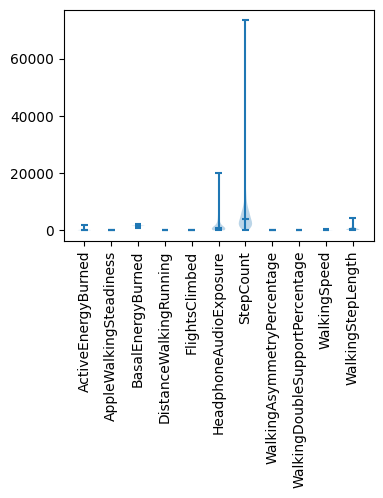

In [ ]:
import matplotlib.pyplot as plt

# Create an empty list to store filtered DataFrames
filts = []

# Apply filters and append to the list
for label in unique_recTypes:
    filt = sums['value'][sums['recordType'] == label]
    filts.append(filt)

plt.figure(figsize = (4,3))

# plot violin plot
plt.violinplot(filts,
                  showmeans=False,
                  showmedians=True)
plt.xticks(np.arange(1, len(unique_recTypes) + 1), unique_recTypes)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

Step count has a much higher maximum value than the other metrics, but headphone audio exposure and walking step length also show a greater amount of variability. This confirms it would be a good idea to scale the variables before doing anything fancy with them - using the `StandardScaler` from SciKitLearn will scale variables so they all have a mean of 0 and a standard deviation of 1.


In [ ]:
# For each record type:
unscaled_dat = np.zeros((len(unique_creationDate),len(unique_recTypes)))
for rti in range(len(unique_recTypes)):
  for cdi in range(len(unique_creationDate)):
    # fill in value from sums data frame - if empty, leave as 0.
    if len(sums['value'][(sums['creationDate'] == unique_creationDate[cdi]) & (sums['recordType'] == unique_recTypes[rti])]) > 0:
      unscaled_dat[cdi,rti] = sums['value'][(sums['creationDate'] == unique_creationDate[cdi]) & (sums['recordType'] == unique_recTypes[rti])]
  print('Max val for '+unique_recTypes[rti]+': '+str(np.max(unscaled_dat[:,rti]))+', Min val: '+str(np.min(unscaled_dat[:,rti])))

# Scale the variables:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dat = scaler.fit_transform(unscaled_dat)
print('**SCALED DAT CHECK (just for first two record types)**')
print('Max val for '+unique_recTypes[0]+': '+str(np.max(scaled_dat[:,0]))+', Min val: '+str(np.min(scaled_dat[:,0])))
print('Max val for '+unique_recTypes[1]+': '+str(np.max(scaled_dat[:,1]))+', Min val: '+str(np.min(scaled_dat[:,1])))

# Make it a dataframe:
df_sc = pd.DataFrame(scaled_dat, columns=unique_recTypes)
df_sc.insert(0, 'CreationDate', unique_creationDate)

<ipython-input-14-33f35baef63e>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unscaled_dat[cdi,rti] = sums['value'][(sums['creationDate'] == unique_creationDate[cdi]) & (sums['recordType'] == unique_recTypes[rti])]


Max val for ActiveEnergyBurned: 1989.464, Min val: 0.0
Max val for AppleWalkingSteadiness: 1.901901, Min val: 0.0
Max val for BasalEnergyBurned: 2297.018, Min val: 0.0
Max val for DistanceWalkingRunning: 31.5151, Min val: 0.0
Max val for FlightsClimbed: 265.0, Min val: 0.0
Max val for HeadphoneAudioExposure: 19953.6388, Min val: 0.0
Max val for StepCount: 73468.0, Min val: 0.0
Max val for WalkingAsymmetryPercentage: 3.7600000000000002, Min val: 0.0
Max val for WalkingDoubleSupportPercentage: 48.139, Min val: 0.0
Max val for WalkingSpeed: 502.08036, Min val: 0.0
Max val for WalkingStepLength: 4428.7385, Min val: 0.0
**SCALED DAT CHECK (just for first two record types)**
Max val for ActiveEnergyBurned: 11.627604525467177, Min val: -0.3749973134615081
Max val for AppleWalkingSteadiness: 7.188997072942679, Min val: -0.2760872189767559


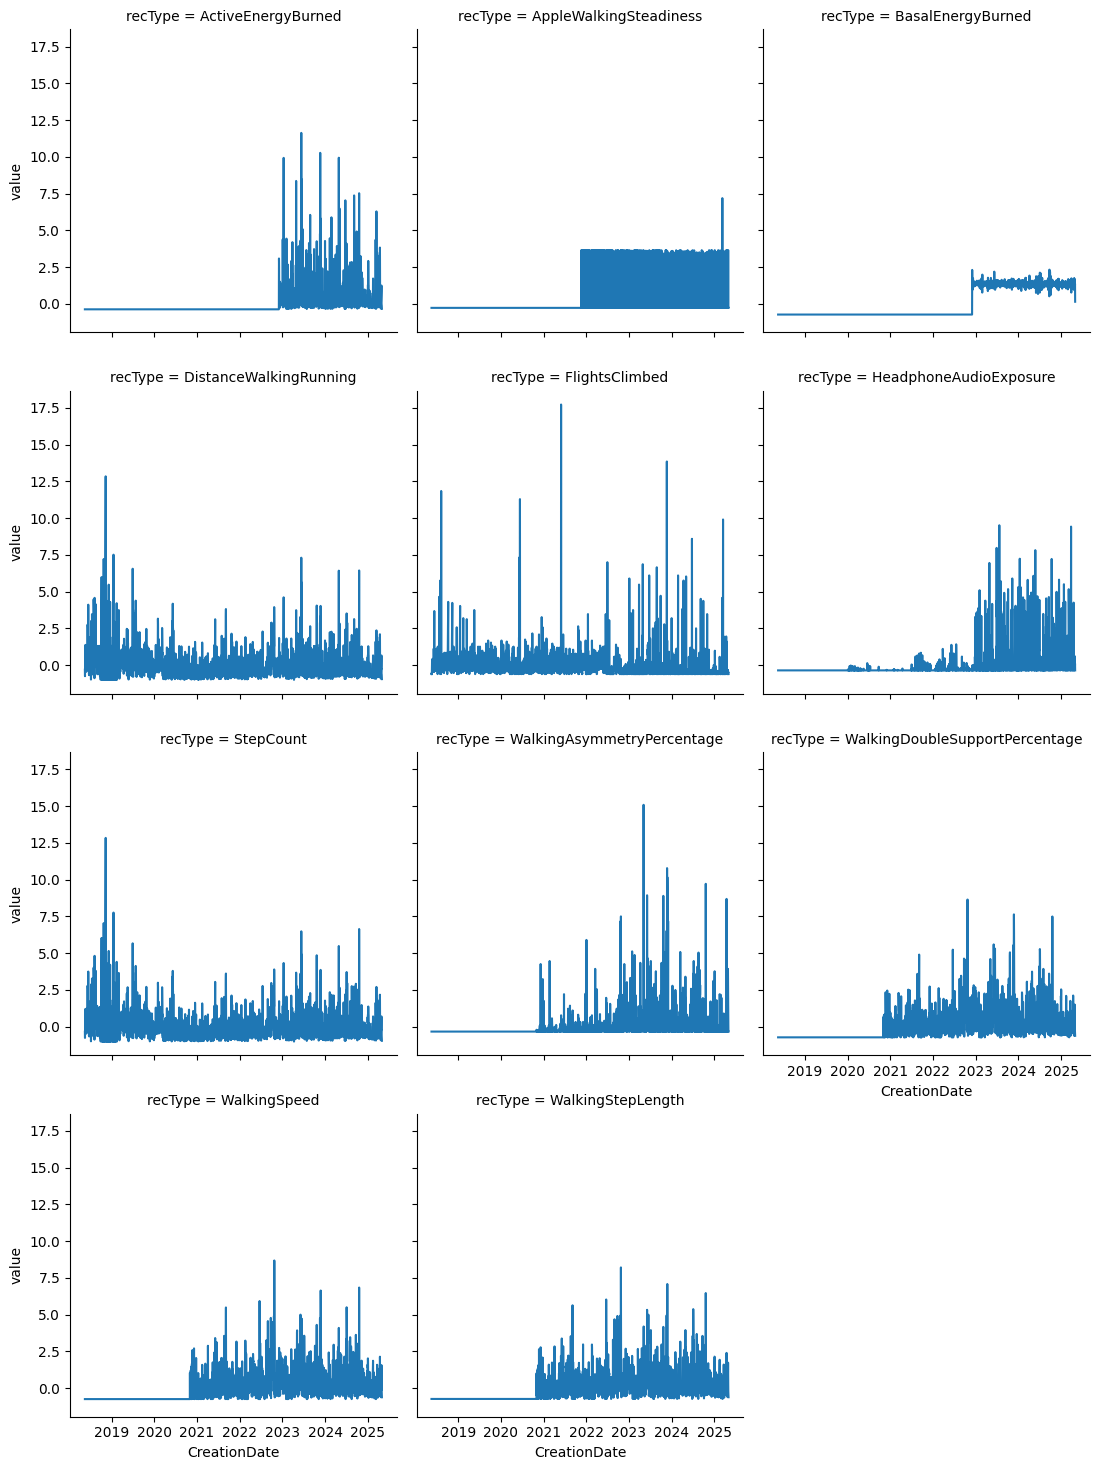

In [ ]:
# unpivot the data frame so each row is a distinct recordtype
df_sc_long = df_sc.melt(id_vars=['CreationDate'],
                    value_vars=unique_recTypes,
                    var_name='recType',
                    value_name='value')

# make faceted plot
import seaborn as sns

sns.relplot(data=df_sc_long, x='CreationDate', y='value', kind='line', col='recType', col_wrap=3,  height=3.7, aspect=1)  # Adjust col_wrap as needed
plt.tight_layout()
plt.show()


One more thing - it looks like some of the record types didn't exist until around the end of 2020 - what happened here? I suspect this is due to me getting a new phone (i.e., a change in `svHardware`) that had new capabilities for measuring health data. Let's test that theory by color-coding the line plots above by `svHardware`.

,CreationDate,recType,value,Hardware
0,2018-05-17,ActiveEnergyBurned,-0.374997,"iPhone10,4"
1,2018-05-18,ActiveEnergyBurned,-0.374997,"iPhone10,4"
2,2018-05-19,ActiveEnergyBurned,-0.374997,"iPhone10,4"
3,2018-05-20,ActiveEnergyBurned,-0.374997,"iPhone10,4"
4,2018-05-21,ActiveEnergyBurned,-0.374997,"iPhone10,4"


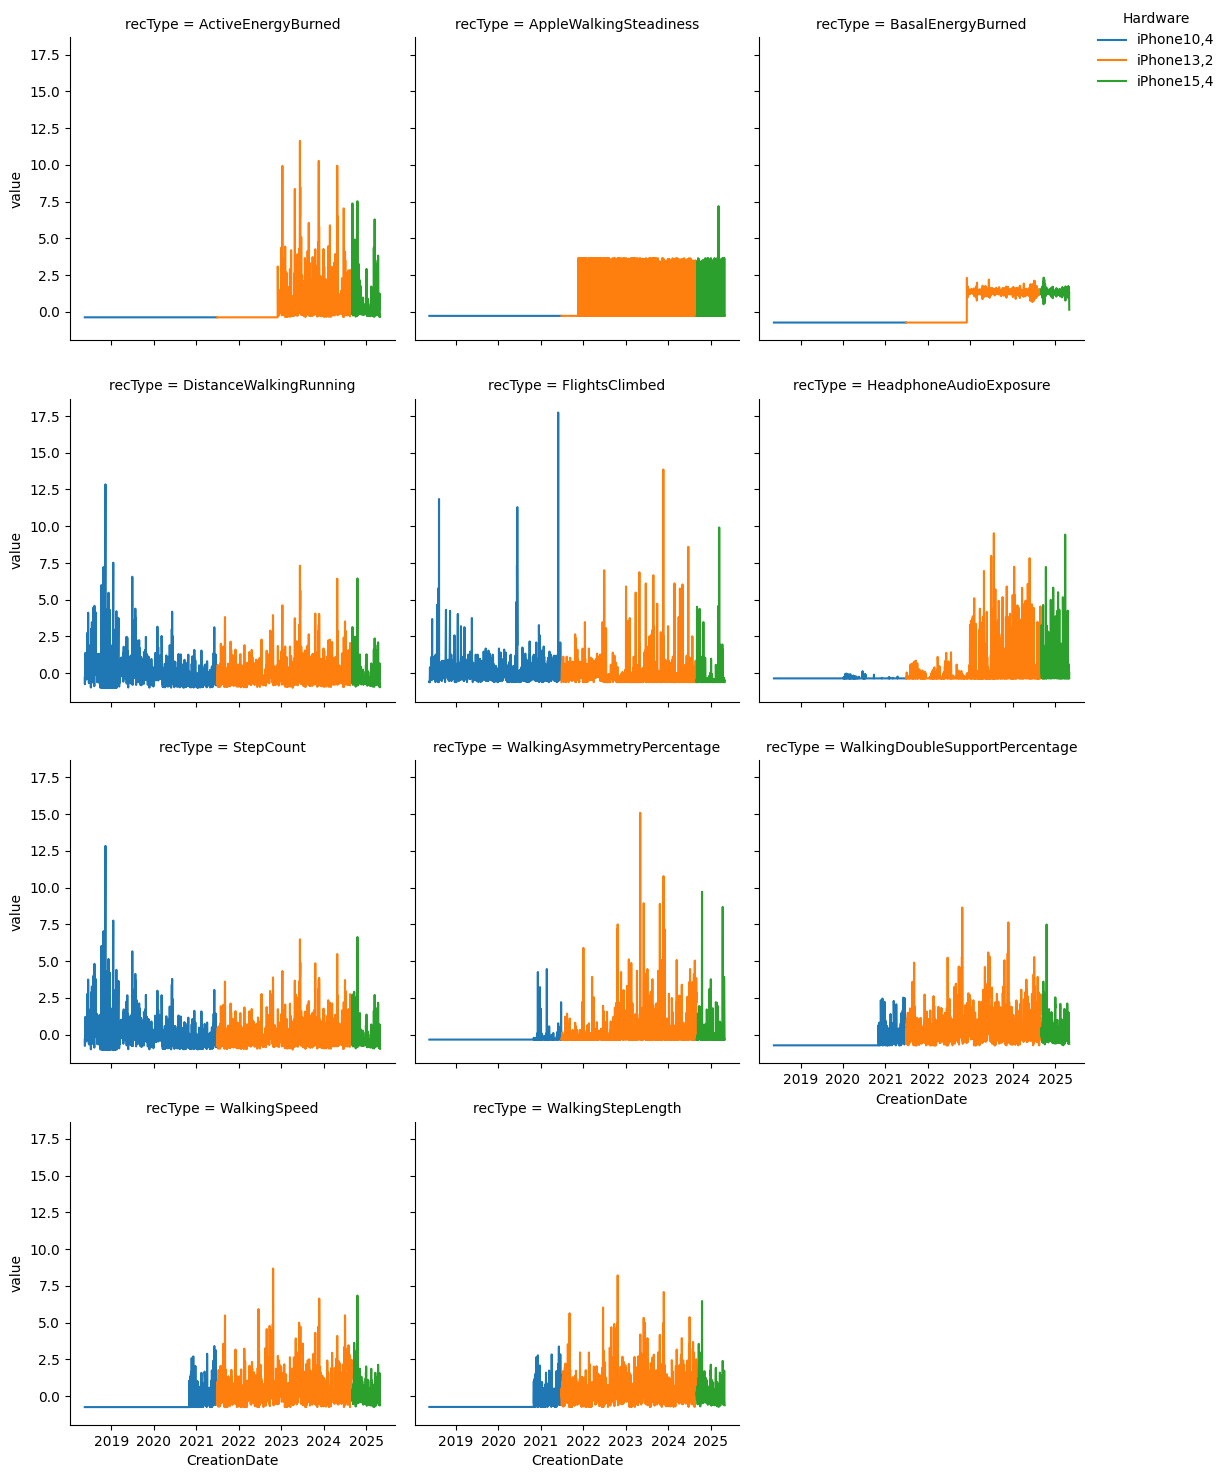

In [ ]:
# identify dominant hardware (most counts) for each date
hw_bydate = df_sp.groupby([df_sp['creationDate'].dt.date, 'svHardware'])['value'].count().reset_index().pivot(index='creationDate', columns='svHardware', values='value').idxmax(axis = "columns").reset_index()
hw_bydate.columns = ['CreationDate','Hardware']

# join to df_sc_long
df_sc_long_whw = df_sc_long.copy() # new version with hardware
df_sc_long_whw = df_sc_long_whw.set_index(pd.to_datetime(df_sc_long_whw['CreationDate'])) # set CreationDate as indexing variable for merge
df_sc_long_whw = pd.merge(df_sc_long_whw, hw_bydate, left_index=True, right_on=pd.to_datetime(hw_bydate['CreationDate']), how='left') # merge hardware info
df_sc_long_whw = df_sc_long_whw.drop(columns = ['CreationDate_x','CreationDate_y']).rename(columns={'key_0': 'CreationDate'}) # tidy up columns
display(df_sc_long_whw.head())

# make new plot
g = sns.relplot(data=df_sc_long_whw, x='CreationDate', y='value', hue = 'Hardware', kind='line', col='recType', col_wrap=3,  height=3.7, aspect=1)  # Adjust col_wrap as needed
sns.move_legend(g, "upper right")
plt.show()

Interestingly, it looks like a lot of these metrics did exist for the earliest hardware in this data - let's look at this same view but for software to see if the change in 2021 could be due to a software change instead.

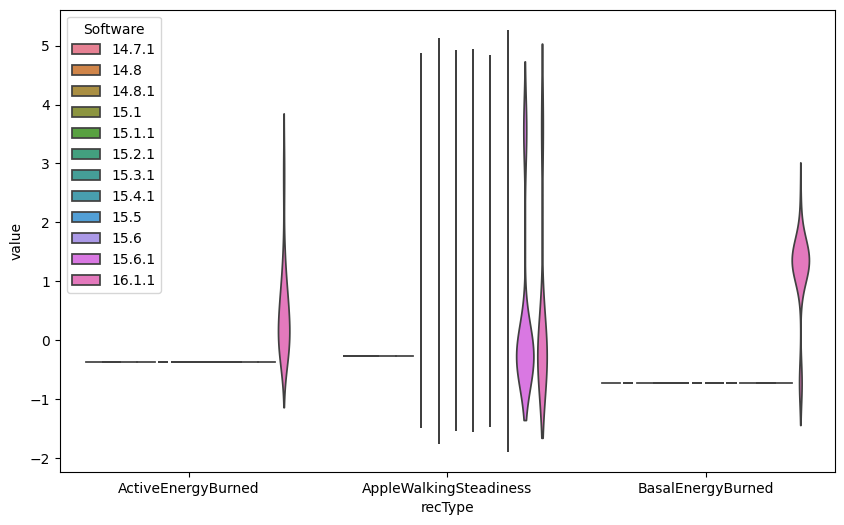

In [ ]:
# identify dominant hardware (most counts) for each date
sw_bydate = df_sp.groupby([df_sp['creationDate'].dt.date, 'svSoftware'])['value'].count().reset_index().pivot(index='creationDate', columns='svSoftware', values='value').idxmax(axis = "columns").reset_index()
sw_bydate.columns = ['CreationDate','Software']

# join to df_sc_long
df_sc_long_whw = df_sc_long_whw.set_index(pd.to_datetime(df_sc_long_whw['CreationDate'])) # set CreationDate as indexing variable for merge
df_sc_long_whw = pd.merge(df_sc_long_whw, sw_bydate, left_index=True, right_on=pd.to_datetime(sw_bydate['CreationDate']), how='left') # merge software info
df_sc_long_whw = df_sc_long_whw.drop(columns = ['CreationDate_x','CreationDate_y']).rename(columns={'key_0': 'CreationDate'}) # tidy up columns

# Identify the record types that seem to be newer (i.e., ones we don't have early data for, based on visual inspection of plot above).
recTypes_1 = unique_recTypes[0:3]
recTypes_2 = unique_recTypes[7:]

filtered_df = df_sc_long_whw[
    (df_sc_long_whw['CreationDate'] >= '2021-09-01') &
    (df_sc_long_whw['CreationDate'] <= '2023-01-01') &
    (df_sc_long_whw['recType'].isin(recTypes_1))
]

plt.figure(figsize = (10,6))
g = sns.violinplot(x='recType', y='value', hue='Software', data=filtered_df, inner=None)
plt.show()


This shows that active and basal energy burned were added with version iOS 16.1.1. Walking steadiness was added with iOS 15.1.1.

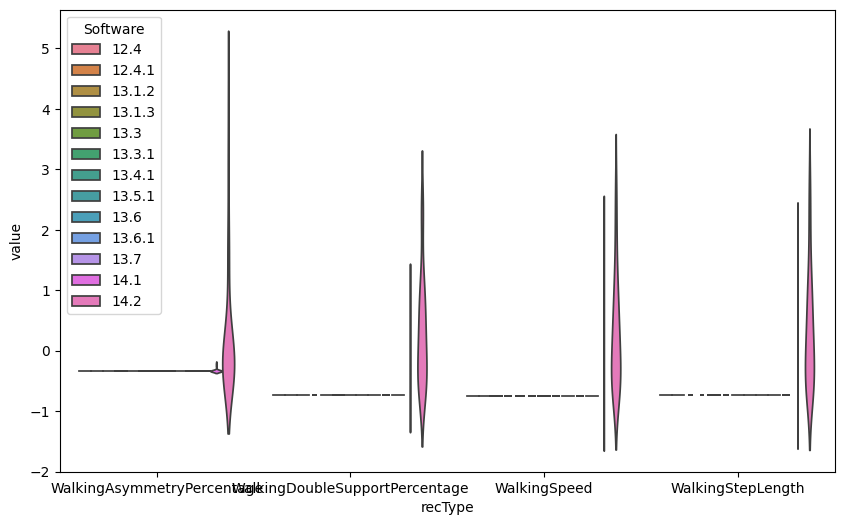

In [ ]:
filtered_df = df_sc_long_whw[
    (df_sc_long_whw['CreationDate'] >= '2019-09-01') &
    (df_sc_long_whw['CreationDate'] <= '2021-01-01') &
    (df_sc_long_whw['recType'].isin(recTypes_2))
]

plt.figure(figsize = (10,6))
g = sns.violinplot(x='recType', y='value', hue='Software', data=filtered_df, inner=None)
plt.show()

...And it looks like walking asymmetry, double support, speed and step length were all added with version iOS 14.1. <br><br> TO BE CONTINUED